In [348]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

## Load data

In [372]:
df = pd.read_csv('data/anime_df_preprocessed.csv', index_col=0)
df.head()

,rating,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Yaoi,Yuri,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,scaled_episodes,scaled_members
0,9.37,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0.000000,0.197867
1,9.26,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0.034673,0.782769
2,9.25,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.027518,0.112683
3,9.17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.012658,0.664323
4,9.16,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.027518,0.149180


In [373]:
X = df.drop('rating', axis=1)
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [374]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8901, 51), (2968, 51), (8901,), (2968,))

In [375]:
regressionResult = {}

## Linear Regression

In [376]:
linearRegression = LinearRegression()
linearRegression.fit(X_train, y_train)
cv_scores = cross_val_score(linearRegression, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
y_pred = linearRegression.predict(X_test)

In [377]:
print(f"Cross-Validation MSE Scores: {cv_scores}")
print(f"Mean Cross-Validation MSE: {cv_scores.mean():.4f}")
print(f"Standard Deviation of Cross-Validation MSE: {cv_scores.std():.4f}")

Cross-Validation MSE Scores: [-0.59767982 -0.67322492 -0.67865629 -0.67359593 -0.66023489]
Mean Cross-Validation MSE: -0.6567
Standard Deviation of Cross-Validation MSE: 0.0301


In [378]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
regressionResult['LinearRegression'] = {"mse": mse, "r2": r2}
print(f"Test Set Mean Squared Error: {mse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")

Test Set Mean Squared Error: 0.6955
Test Set R-squared: 0.3475


## Ridge Regression

In [379]:
ridgeRegression = RidgeCV()
ridgeRegression.fit(X_train, y_train)
y_pred = ridgeRegression.predict(X_test)

In [380]:
print(f"Best alpha: {ridgeRegression.alpha_}")

Best alpha: 1.0


In [381]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
regressionResult['RidgeCV'] = {"mse": mse, "r2": r2}
print(f"Test Set Mean Squared Error: {mse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")

Test Set Mean Squared Error: 0.6965
Test Set R-squared: 0.3465


## GradientBoostingRegressor

In [382]:
gbRegressor = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [10, 20, 50, 100, 300, 500],
    'max_depth': [3, 5, 7, 9],
}
randomSearch = RandomizedSearchCV(estimator=gbRegressor, param_distributions=param_grid, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
randomSearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [10, 20, 50, 100, 300,
                                                         500]},
                   scoring='neg_mean_squared_error')

In [383]:
print(f"Best hyperparameters: {randomSearch.best_params_}")

Best hyperparameters: {'n_estimators': 100, 'max_depth': 5}


In [397]:
best_gb = randomSearch.best_estimator_
gb_y_pred = best_gb.predict(X_test)

In [398]:
mse = mean_squared_error(y_test, gb_y_pred)
r2 = r2_score(y_test, gb_y_pred)

regressionResult['GradientBoostingRegressor'] = {"mse": mse, "r2": r2}

# Print evaluation metrics
print(f"Test Set Mean Squared Error: {mse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")

Test Set Mean Squared Error: 0.5968
Test Set R-squared: 0.4401


## RandomForestRegressor

In [388]:
rfRegressor = RandomForestRegressor()

param_grid= {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'bootstrap': [True, False]
}

randomSearch = RandomizedSearchCV(estimator=rfRegressor, param_distributions=param_grid, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
randomSearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'n_estimators': [100, 300, 500]},
                   scoring='neg_mean_squared_error')

In [389]:
print(f"Best hyperparameters: {randomSearch.best_params_}")

Best hyperparameters: {'n_estimators': 500, 'max_depth': 20, 'bootstrap': True}


In [390]:
best_rf = randomSearch.best_estimator_
rf_y_pred = best_rf.predict(X_test)

In [391]:
mse = mean_squared_error(y_test, rf_y_pred)
r2 = r2_score(y_test, rf_y_pred)

regressionResult['RandomForestRegressor'] = {"mse": mse, "r2": r2}

# Print evaluation metrics
print(f"Test Set Mean Squared Error: {mse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")

Test Set Mean Squared Error: 0.4294
Test Set R-squared: 0.5971


## KNN

In [392]:
knn = KNeighborsRegressor()

param_grid= {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

randomSearch = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
randomSearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan',
                                                   'minkowski'],
                                        'n_neighbors': [3, 5, 7, 9, 11],
                                        'weights': ['uniform', 'distance']},
                   scoring='neg_mean_squared_error')

In [393]:
print(f"Best hyperparameters: {randomSearch.best_params_}")

Best hyperparameters: {'weights': 'uniform', 'n_neighbors': 7, 'metric': 'manhattan'}


In [394]:
best_knn = randomSearch.best_estimator_
y_pred = best_knn.predict(X_test)

In [395]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

regressionResult['KNeighborsRegressor'] = {"mse": mse, "r2": r2}

# Print evaluation metrics
print(f"Test Set Mean Squared Error: {mse:.4f}")
print(f"Test Set R-squared: {r2:.4f}")

Test Set Mean Squared Error: 0.5968
Test Set R-squared: 0.4401


## Results

In [400]:
pd.DataFrame(regressionResult).T

,mse,r2
LinearRegression,0.695478,0.347477
RidgeCV,0.696503,0.346515
GradientBoostingRegressor,0.596795,0.440065
RandomForestRegressor,0.429412,0.597110
KNeighborsRegressor,0.596795,0.440065


GradientBoostingRegressor seems to be the best modale with leaset MSE and best R2 scores

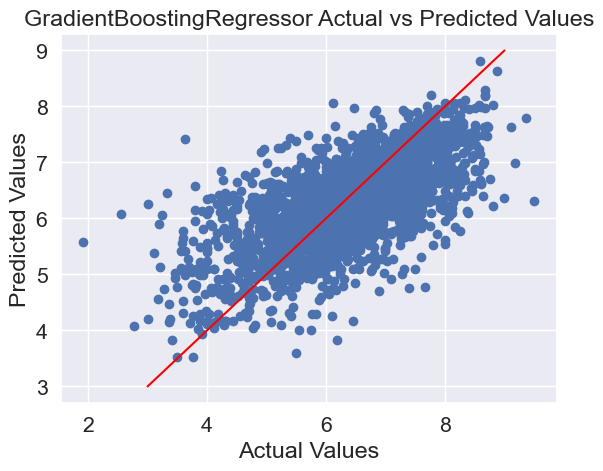

In [405]:
plt.scatter(y_test, gb_y_pred)
plt.plot([x for x in range(3,10)],[x for x in range(3,10)], color='red')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('GradientBoostingRegressor Actual vs Predicted Values')
plt.show()

## Bin rating into low, mid, high

In [319]:
# Define bins and labels
bins = [0, 5, 8, 10]  # Define bin edges
labels = ['low', 'mid', 'high']  # Define bin labels

# Bin the data
df['binned_rating'] = pd.cut(df['rating'], bins=bins, labels=labels, include_lowest=True)

In [321]:
df.head()

,rating,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,...,Yuri,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,scaled_episodes,scaled_members,binned_rating
0,9.37,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0.000000,0.197867,high
1,9.26,1,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0.034673,0.782769,high
2,9.25,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0.027518,0.112683,high
3,9.17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.012658,0.664323,high
4,9.16,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0.027518,0.149180,high


<Axes: >

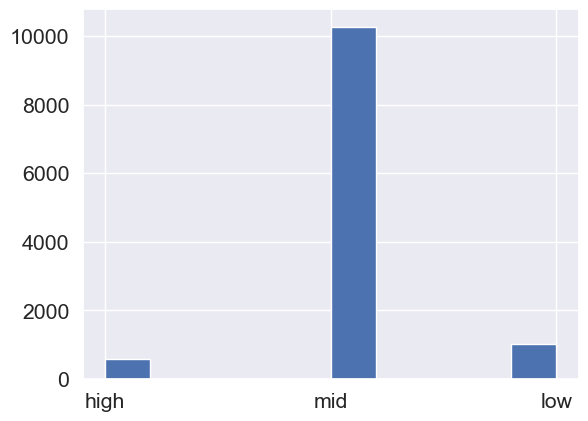

In [369]:
df['binned_rating'].hist()

### Under sampling

In [346]:
X = df.drop(columns=['rating','binned_rating'])
y = df['binned_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [351]:
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

<Axes: >

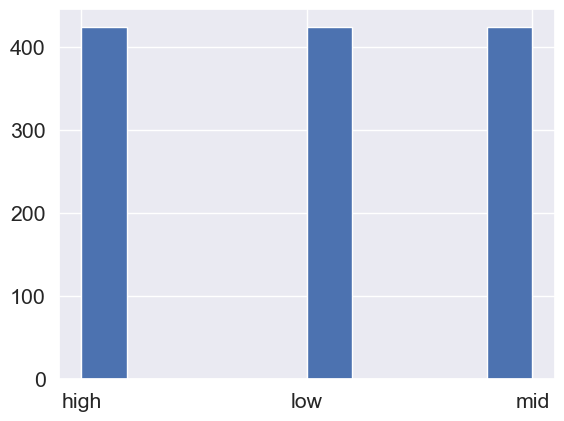

In [354]:
y_train_resampled.hist()

## GradientBoostingClassifier

In [356]:
gbClassifier = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 1.0],
    'max_depth': [3, 5, 7, 9],
}
randomSearch = RandomizedSearchCV(estimator=gbClassifier, param_distributions=param_grid, cv=5, n_jobs=-1)
randomSearch.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 1.0],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [100, 300, 500]})

In [357]:
print(f"Best hyperparameters: {randomSearch.best_params_}")

Best hyperparameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05}


In [358]:
best_gb = randomSearch.best_estimator_
y_pred = best_gb.predict(X_test)

In [359]:
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
cm = confusion_matrix(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

        high       0.23      0.83      0.36       153
         low       0.27      0.83      0.41       245
         mid       0.97      0.63      0.76      2570

    accuracy                           0.65      2968
   macro avg       0.49      0.76      0.51      2968
weighted avg       0.87      0.65      0.71      2968



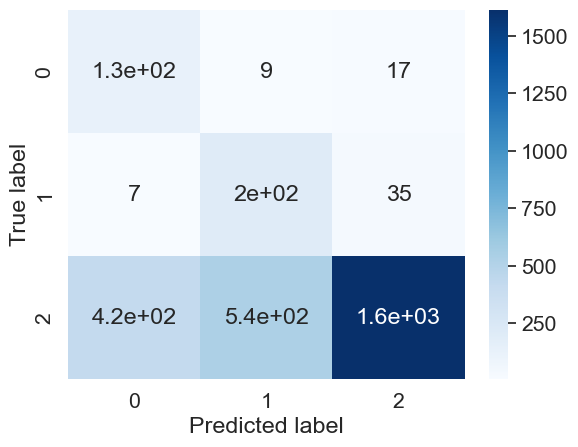

In [361]:
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## BalancedRandomForestClassifier

In [362]:
rfClassifier = RandomForestClassifier()

param_grid= {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'bootstrap': [True, False]
}

randomSearch = RandomizedSearchCV(estimator=rfClassifier, param_distributions=param_grid, cv=5, n_jobs=-1)
randomSearch.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'n_estimators': [100, 300, 500]})

In [363]:
print(f"Best hyperparameters: {randomSearch.best_params_}")

Best hyperparameters: {'n_estimators': 100, 'max_depth': 10, 'bootstrap': False}


In [364]:
best_rf = randomSearch.best_estimator_
y_pred = best_rf.predict(X_test)

In [365]:
print(rfClassifier.class_weight)

None


In [366]:
report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{report}")
cm = confusion_matrix(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

        high       0.24      0.87      0.37       153
         low       0.25      0.84      0.39       245
         mid       0.97      0.60      0.74      2570

    accuracy                           0.63      2968
   macro avg       0.49      0.77      0.50      2968
weighted avg       0.87      0.63      0.69      2968



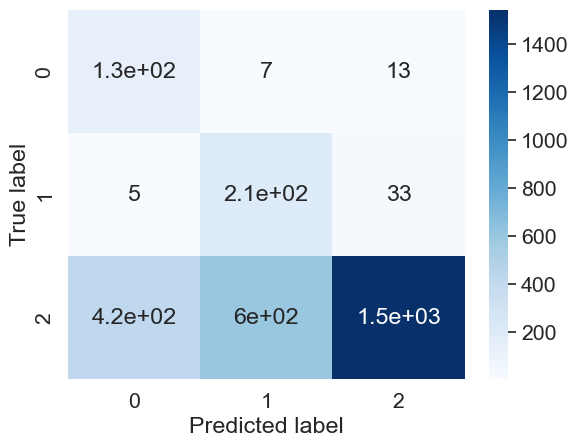

In [368]:
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()